In [139]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [142]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figure').absolute()

df_meta_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' /  'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

# Motif counts 5PPI

In [143]:
import networkx as nx
from sklearn.preprocessing import OneHotEncoder

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

In [144]:
# Get encoder 
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
        
df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df['PPI'].to_numpy().reshape(-1, 1))
labels = enc.transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)

In [145]:
mappings = {}
for ppi in df['PPI'].unique():
    mappings[ppi]=enc.transform(np.array([ppi]).reshape(-1, 1)).toarray().astype(np.uint8)[0]

In [146]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']


In [147]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)

In [148]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [149]:
# Filter out by maximum number of counts per cell
min_count = 20
max_count = 70

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

,Count_cell,Count_nuclei,Count_cyto
count,1510.000000,1510.000000,1510.000000
mean,67.668212,33.149007,34.519205
std,31.996032,16.639663,24.150085
min,21.000000,0.000000,1.000000
25%,43.000000,22.000000,17.000000
50%,63.000000,31.000000,29.000000
75%,87.000000,43.000000,45.000000
max,292.000000,143.000000,246.000000


In [150]:
df_all = df_all[df_all['Count_cyto']>=0]

In [151]:
df_cell = df_all.drop_duplicates(['Condition', 'FOV', 'Id'])[['Condition', 'FOV', 'Id']]
df_cell = df_cell.astype(str)

In [152]:
import PLA

graph_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'graphs' / 'raw'
contour_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [153]:
df_new = df_cell.merge(cell_data.df, how='left', left_on=['Condition', 'FOV', 'Id'], 
              right_on=['Condition', 'FOV', 'Cell'])

In [154]:
from itertools import combinations_with_replacement
from grandiso import find_motifs

def generate_list_motifs(PPI_pairs, n=3):
    '''
    Generate list of possible motifs of size n from PPI pairs
    '''
    
    comb = []
    for i in range(2,n+1):
        comb += list(combinations_with_replacement(PPI_pairs, i))
    return comb 

def count_motifs(network, comb, mappings=mappings):
    motifs = []
    counts = []
    for c in comb:
        motif=nx.complete_graph(len(c))
        labels = {i:mappings[marker].tolist() for i,marker in enumerate(c)}
        nx.set_node_attributes(motif, labels, "labels")

        motifs.append(motif)
        counts.append(len(find_motifs(motif, network)))
        
    return motifs, counts

In [155]:
# Count motfis
PPI_pairs = list(mappings.keys())
comb = generate_list_motifs(PPI_pairs, n=3)
counts_all = []
ids = []
conditions = []

# for i in range(len(df_new)):
#     # Info
#     row = df_new.iloc[i]
#     key = '_'.join(row.iloc[:2])
    
#     cell = row.iloc[2]
#     conditions.append(row.iloc[0])
#     # Get graph
#     network = read_pkl(row.Path)
    
#     if not nx.is_connected(network):
#         print(row)
    
#     # Get PPI counts
#     network.remove_edges_from(nx.selfloop_edges(network))
#     motifs, counts = count_motifs(network, comb)
#     counts_all.append(counts)
#     ids.append(key+'_'+cell)


In [156]:
# df_count_motifs = pd.DataFrame(counts_all, index=ids)
# df_count_motifs['Condition'] = conditions
# df_count_motifs = df_count_motifs.loc[:, (df_count_motifs != 0).any(axis=0)]
# df_labels = pd.DataFrame(comb, columns=['PPI1', 'PPI2', 'PPI3'])

In [157]:
# df_count_motifs

In [158]:
# save_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' /  'motifs.csv'
# df_count_motifs.to_csv(save_path, index=False)

# save_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' /  'motifs_labels.csv'
# df_labels.to_csv(save_path)

In [159]:
# save_path

In [160]:
import matplotlib 

PPIs_name = list(mappings.keys())
# Define colormap
colors = [ '#ff00ff', '#00FF00', '#FF0000',  '#00FFFF', '#FFFF00']

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

In [161]:
colors_rgb_dict

{'TEAD1 & YAP1': array([255,   0, 255], dtype=uint8),
 'CylinE & CDK2': array([  0, 255,   0], dtype=uint8),
 'P-ERK & c-MYC': array([255,   0,   0], dtype=uint8),
 'p-AKT & mTOR': array([  0, 255, 255], dtype=uint8),
 'Mcl-1 & BAK': array([255, 255,   0], dtype=uint8)}

In [162]:
save_dir = fig_dir / 'PPI count'/ '5PPI'
save_dir.mkdir(parents=True, exist_ok=True)

# for i, c in enumerate(comb):
    
#     motif=nx.complete_graph(len(c))
#     labels = {i:mappings[marker].tolist() for i,marker in enumerate(c)}
#     nx.set_node_attributes(motif, labels, "labels")

#     plt.figure(1, figsize=(2, 2))
#     # layout graphs with positions using graphviz neato
#     pos = nx.spring_layout(motif)
    
#     # color nodes the same in each connected subgraph
#     labels = list(nx.get_node_attributes(motif, 'labels').values())
#     labels = np.argmax(labels, axis=1)
#     node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
#     nx.draw(motif, pos, node_size=200, node_color=node_colors, vmin=0.0, vmax=1.0, with_labels=False, edgecolors='k')
    
#     plt.savefig(save_dir / f"{i}_{c}.png")
#     plt.close()

In [163]:
save_dir = fig_dir / 'PPI count'/ 'examples'
save_dir.mkdir(parents=True, exist_ok=True)

In [164]:
def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass
    
def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax


In [165]:
comb_indices = [9, 15, 17, 24, 40]

for i in range(len(df_new.sample(10, random_state=123))):
    # Info
    row = df_new.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    conditions.append(row.iloc[0])
    # Get graph
    network = read_pkl(row.Path)
    
    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    contour = max(contour_cell, key = len)
    
    # Plot original
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    nodes = list(network.nodes())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[l]]/255 for i,l in zip(nodes, labels) ]

    # Plot network
    with plt.style.context('dark_background'):
        # Plot Graph
        fig, ax = plt.subplots(figsize=(4,4), facecolor='k')
        plot_network(network,  node_colors, ax, node_size=45, linewidths=0, edgecolors='w', width=1.2, edge_color='w')
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
        ax.set_facecolor('k')
        fig.savefig(save_dir / f'5PPI_{key}_{cell}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)

    for c_index in comb_indices:
        c = comb[c_index]
        motif=nx.complete_graph(len(c))
        labels_c = {i:mappings[marker].tolist() for i,marker in enumerate(c)}
        nx.set_node_attributes(motif, labels_c, "labels")
        search = find_motifs(motif, network)
        search_unique = np.unique(np.array([(list(s.values())) for s in search]).flatten())
        search_edges = [(list(s.values())[0], list(s.values())[1]) for s in search]

        # Plot only one type of motifs
        node_colors = [colors_rgb_dict[PPIs_name[l]]/255
                       if i in search_unique 
                       else np.array([120,120,120])/255
                       for i,l in zip(nodes, labels) 
                      ]

        edge_colors = [np.array([255,0,0])/255
                       if (e[0], e[1]) in search_edges 
                       else np.array([120,120,120])/255
                       for e in network.edges()
                      ]

        # Plot network
        with plt.style.context('dark_background'):
            # Plot Graph
            fig, ax = plt.subplots(figsize=(4,4), facecolor='k')
            plot_network(network,  node_colors, ax, node_size=45, linewidths=0, edgecolors='w', width=1.2, edge_color=edge_colors)
            plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
            ax.set_facecolor('k')
            fig.savefig(save_dir / f'5PPI_{key}_{cell}_{c}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
            plt.close()

# Motifs count 9PPI

In [166]:
# Get encoder 
PPI_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
        
df = pd.concat(dfs)
df = df[df.PPI.isin(['Cyclin D1 & CDK2', 'NF-Kb & p-P90rsk', 'Sox2 & Oct4',
       'Bim & Tom20', 'Mcl-1 & BAK', 'p-ERK & c-MYC', 'TEAD1 & YAP',
       'Cyclin E & CDK4', 'P-AKT & mTOR'])]

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df['PPI'].to_numpy().reshape(-1, 1))
labels = enc.transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)

In [167]:
mappings = {}
for ppi in df['PPI'].unique():
    mappings[ppi]=enc.transform(np.array([ppi]).reshape(-1, 1)).toarray().astype(np.uint8)[0]

In [168]:
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']


In [169]:
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)

In [170]:
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [171]:
# Filter out by maximum number of counts per cell
min_count = 100
max_count = 400

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()

,Count_cell,Count_nuclei,Count_cyto
count,1340.000000,1340.000000,1340.000000
mean,336.203731,122.502985,213.700746
std,142.753623,50.508549,118.238184
min,102.000000,0.000000,-32.000000
25%,225.500000,90.000000,125.000000
50%,315.000000,119.000000,194.000000
75%,426.000000,151.000000,286.250000
max,1202.000000,412.000000,1202.000000


In [172]:
df_all = df_all[df_all['Count_cyto']>=0]

In [173]:
df_cell = df_all.drop_duplicates(['Condition', 'FOV', 'Id'])[['Condition', 'FOV', 'Id']]
df_cell = df_cell.astype(str)

In [174]:
import PLA

graph_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'graphs' / 'raw'
contour_save_path =  data_dir / '9PPI Cell Culture' / 'Whole' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [175]:
df_new = df_cell.merge(cell_data.df, how='left', left_on=['Condition', 'FOV', 'Id'], 
              right_on=['Condition', 'FOV', 'Cell'])

In [176]:
PPI_pairs = list(mappings.keys())
comb = generate_list_motifs(PPI_pairs, n=3)
counts_all = []
ids = []

# conditions = []
# for i in range(len(df_new)):
#     # Info
#     row = df_new.iloc[i]
#     key = '_'.join(row.iloc[:2])
    
#     cell = row.iloc[2]
#     conditions.append(row.iloc[0])
#     # Get graph
#     network = read_pkl(row.Path)
    
#     if not nx.is_connected(network):
#         print(row)
    
#     # Get PPI counts
#     network.remove_edges_from(nx.selfloop_edges(network))
#     motifs, counts = count_motifs(network, comb, mappings=mappings)
#     counts_all.append(counts)
#     ids.append(key+'_'+cell)


In [177]:
# df_count_motifs = pd.DataFrame(counts_all, index=ids)
# df_count_motifs['Condition'] = conditions
# df_count_motifs = df_count_motifs.loc[:, (df_count_motifs != 0).any(axis=0)]
# df_labels = pd.DataFrame(comb, columns=['PPI1', 'PPI2', 'PPI3'])

In [178]:
# df_count_motifs

In [179]:
# save_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' /  'motifs.csv'
# df_count_motifs.to_csv(save_path, index=False)

# save_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' /  'motifs_labels.csv'
# df_labels.to_csv(save_path)

In [180]:
import palettable

ppi_colors = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

In [181]:
import matplotlib 

PPIs_name = list(mappings.keys())
# Define colormap
colors = ppi_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

In [182]:
colors_rgb_dict

{'Cyclin D1 & CDK2': array([228,  26,  28], dtype=uint8),
 'NF-Kb & p-P90rsk': array([ 55, 126, 184], dtype=uint8),
 'Sox2 & Oct4': array([ 77, 175,  74], dtype=uint8),
 'Bim & Tom20': array([152,  78, 163], dtype=uint8),
 'Mcl-1 & BAK': array([255, 127,   0], dtype=uint8),
 'p-ERK & c-MYC': array([255, 255,  51], dtype=uint8),
 'TEAD1 & YAP': array([166,  86,  40], dtype=uint8),
 'Cyclin E & CDK4': array([247, 129, 191], dtype=uint8),
 'P-AKT & mTOR': array([153, 153, 153], dtype=uint8)}

In [183]:
# save_dir = fig_dir / 'PPI count'/ '9PPI'
# save_dir.mkdir(parents=True, exist_ok=True)

# for i, c in enumerate(comb):
    
#     motif=nx.complete_graph(len(c))
#     labels = {i:mappings[marker].tolist() for i,marker in enumerate(c)}
#     nx.set_node_attributes(motif, labels, "labels")

#     plt.figure(1, figsize=(2, 2))
#     # layout graphs with positions using graphviz neato
#     pos = nx.spring_layout(motif)
    
#     # color nodes the same in each connected subgraph
#     labels = list(nx.get_node_attributes(motif, 'labels').values())
#     labels = np.argmax(labels, axis=1)
#     node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
#     nx.draw(motif, pos, node_size=200, node_color=node_colors, vmin=0.0, vmax=1.0, with_labels=False, edgecolors='k')
    
#     plt.savefig(save_dir / f"{i}_{c}.png")
#     plt.close()

In [184]:
save_dir = fig_dir / 'PPI count'/ 'examples'
save_dir.mkdir(parents=True, exist_ok=True)

In [185]:
def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass
    
def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax


In [186]:
comb_indices = [0, 1, 2, 3, 5, 45, 47, 48]

for i in range(len(df_new.sample(10, random_state=123))):
    # Info
    row = df_new.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    conditions.append(row.iloc[0])
    # Get graph
    network = read_pkl(row.Path)
    
    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    contour = max(contour_cell, key = len)
    
    # Plot original
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    nodes = list(network.nodes())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[l]]/255 for i,l in zip(nodes, labels) ]

    # Plot network
    with plt.style.context('dark_background'):
        # Plot Graph
        fig, ax = plt.subplots(figsize=(4,4), facecolor='k')
        plot_network(network,  node_colors, ax, node_size=35, linewidths=0, edgecolors='w', width=1, edge_color='w')
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
        ax.set_facecolor('k')
        fig.savefig(save_dir / f'9PPI_{key}_{cell}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)

    for c_index in comb_indices:
        c = comb[c_index]
        motif=nx.complete_graph(len(c))
        labels_c = {i:mappings[marker].tolist() for i,marker in enumerate(c)}
        nx.set_node_attributes(motif, labels_c, "labels")
        search = find_motifs(motif, network)
        search_unique = np.unique(np.array([(list(s.values())) for s in search]).flatten())
        search_edges = [(list(s.values())[0], list(s.values())[1]) for s in search]

        # Plot only one type of motifs
        node_colors = [colors_rgb_dict[PPIs_name[l]]/255
                       if i in search_unique 
                       else np.array([120,120,120])/255
                       for i,l in zip(nodes, labels) 
                      ]

        edge_colors = [np.array([255,0,0])/255
                       if (e[0], e[1]) in search_edges 
                       else np.array([120,120,120])/255
                       for e in network.edges()
                      ]

        # Plot network
        with plt.style.context('dark_background'):
            # Plot Graph
            fig, ax = plt.subplots(figsize=(4,4), facecolor='k')
            plot_network(network,  node_colors, ax, node_size=35, linewidths=0, edgecolors='w', width=1, edge_color=edge_colors)
            plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
            ax.set_facecolor('k')
            fig.savefig(save_dir / f'9PPI_{key}_{cell}_{c}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
            plt.close()

# Plot

## statistical plot

In [5]:
from statannotations.Annotator import Annotator

def plot(plotting):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1):
        fig, ax = plt.subplots(figsize=(20,4))
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        # plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Raw count

In [6]:
save_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' /  'motifs.csv'

df_5ppi = pd.read_csv(save_path)
df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>5).tolist()+[True]]


C:\Users\thu71\AppData\Local\Temp\ipykernel_60412\4034278106.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>5).tolist()+[True]]


In [7]:
df_melt = df_5ppi.melt(id_vars=['Condition'], var_name='PPI motif', value_name='Count')

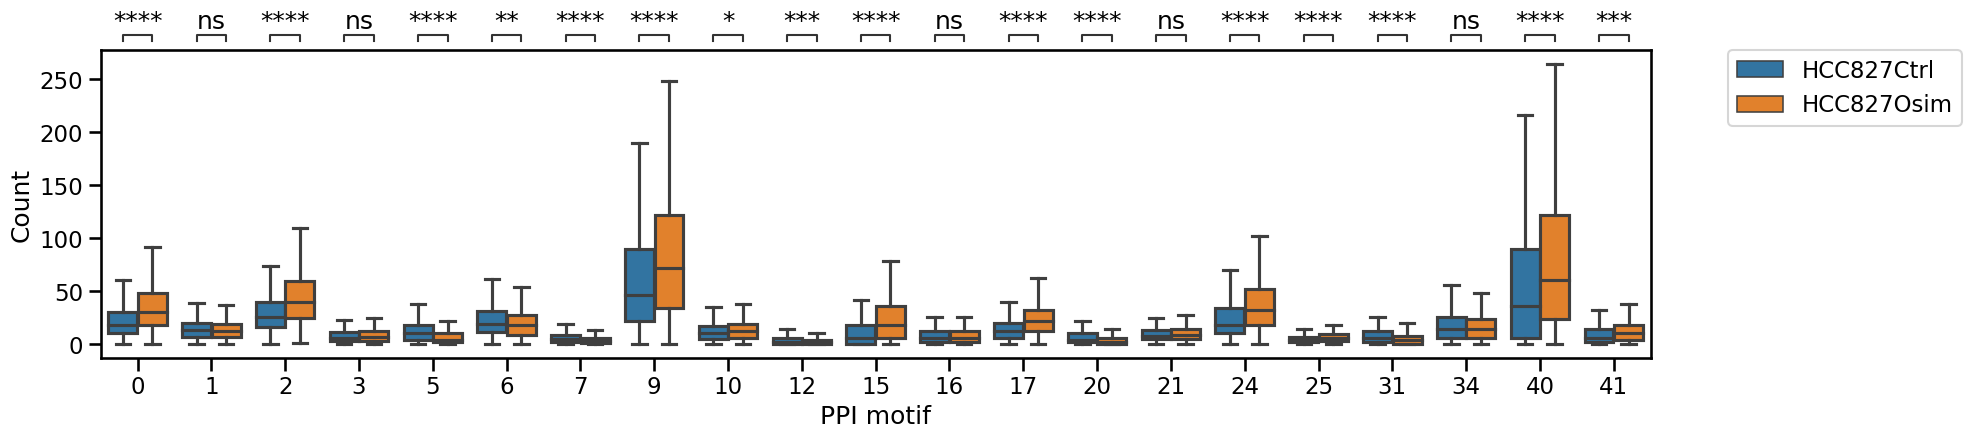

In [8]:
# Boxplot per cell
plotting = {
    "data": df_melt,
    "x": "PPI motif",
    "y": "Count",
    "hue": "Condition"
}

plot(plotting)

In [13]:
save_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' /  'motifs.csv'

df_5ppi = pd.read_csv(save_path)
df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>10).tolist()+[True]]


C:\Users\thu71\AppData\Local\Temp\ipykernel_60412\1745520590.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>10).tolist()+[True]]


In [14]:
df_melt = df_5ppi.melt(id_vars=['Condition'], var_name='PPI motif', value_name='Count')

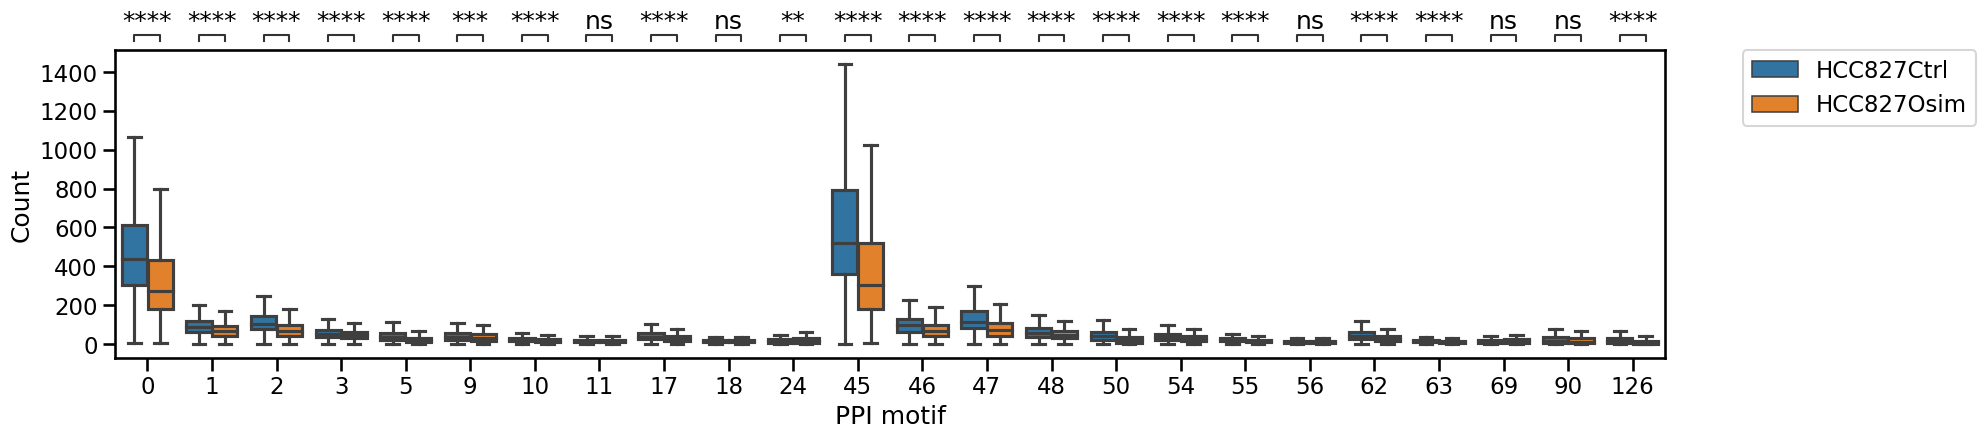

In [15]:
# Boxplot per cell
plotting = {
    "data": df_melt,
    "x": "PPI motif",
    "y": "Count",
    "hue": "Condition"
}

plot(plotting)

### Frequency

In [31]:
save_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' /  'motifs.csv'

df_5ppi = pd.read_csv(save_path)
df_5ppi.iloc[:,:-1] = df_5ppi.iloc[:,:-1].div(df_5ppi.sum(1), axis=0)
df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>0.01).tolist()+[True]]


C:\Users\thu71\AppData\Local\Temp\ipykernel_60412\1256249833.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_5ppi.iloc[:,:-1] = df_5ppi.iloc[:,:-1].div(df_5ppi.sum(1), axis=0)
C:\Users\thu71\AppData\Local\Temp\ipykernel_60412\1256249833.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>0.01).tolist()+[True]]


In [32]:
df_melt = df_5ppi.melt(id_vars=['Condition'], var_name='PPI motif', value_name='Frequency')

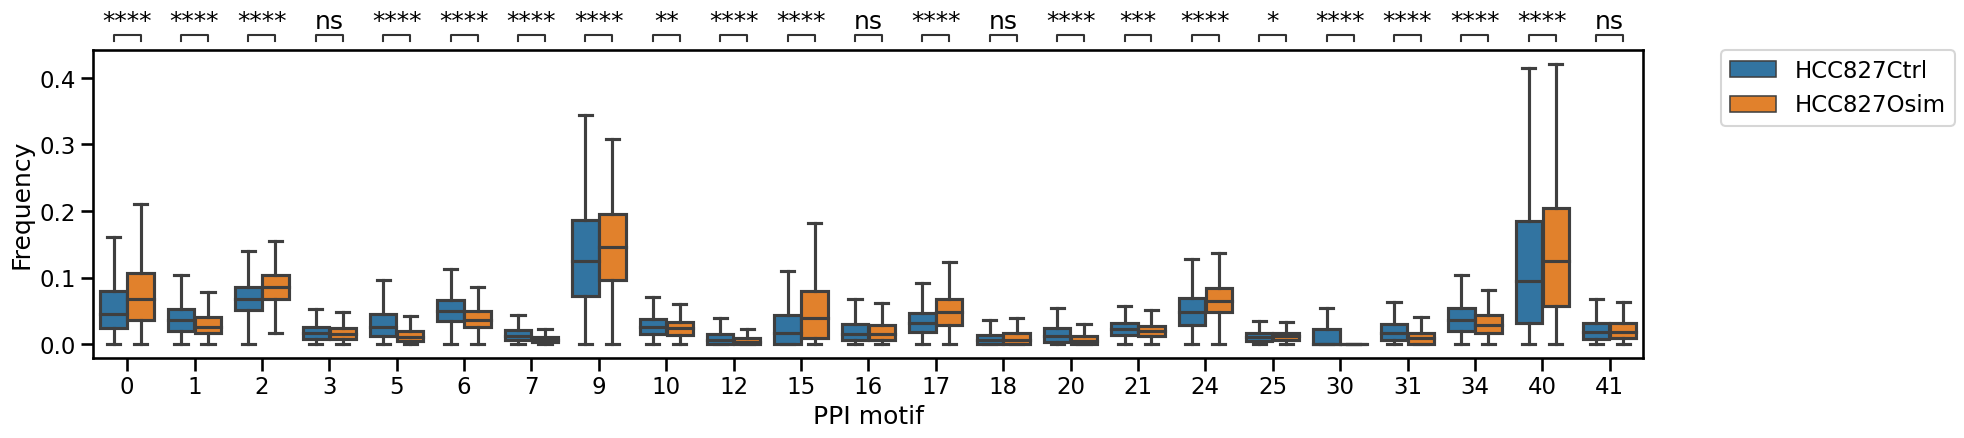

In [33]:
# Boxplot per cell
plotting = {
    "data": df_melt,
    "x": "PPI motif",
    "y": "Frequency",
    "hue": "Condition"
}

plot(plotting)

In [38]:
save_path = data_dir / '9PPI Cell Culture' / 'Whole' / 'metadata' /  'motifs.csv'

df_5ppi = pd.read_csv(save_path)
df_5ppi.iloc[:,:-1] = df_5ppi.iloc[:,:-1].div(df_5ppi.sum(1), axis=0)
df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>0.008).tolist()+[True]]


C:\Users\thu71\AppData\Local\Temp\ipykernel_60412\1942991128.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_5ppi.iloc[:,:-1] = df_5ppi.iloc[:,:-1].div(df_5ppi.sum(1), axis=0)
C:\Users\thu71\AppData\Local\Temp\ipykernel_60412\1942991128.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_5ppi = df_5ppi.loc[:,(df_5ppi.mean(axis=0)>0.008).tolist()+[True]]


In [39]:
df_melt = df_5ppi.melt(id_vars=['Condition'], var_name='PPI motif', value_name='Frequency')

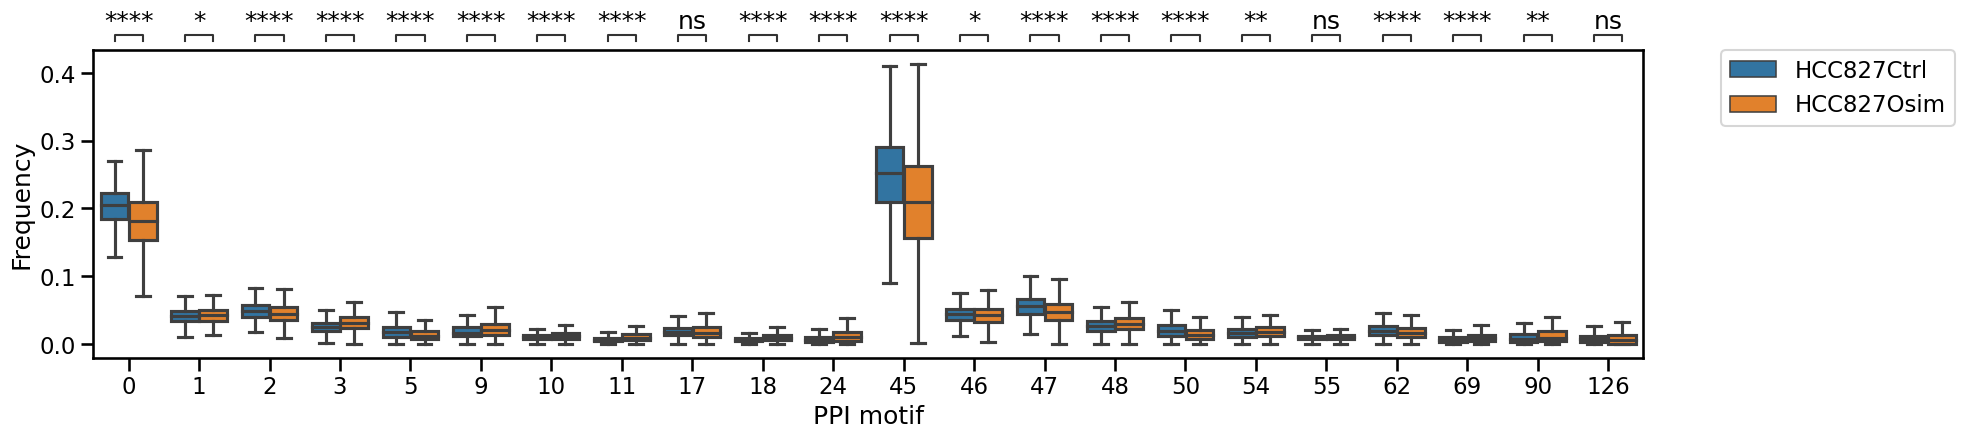

In [40]:
# Boxplot per cell
plotting = {
    "data": df_melt,
    "x": "PPI motif",
    "y": "Frequency",
    "hue": "Condition"
}

plot(plotting)

# Plot example